In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('car_price_prediction_updated.csv')
data.head()

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags,Age
0,13328,1399.000000,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,Left wheel,Silver,12,15
1,16621,1018.000000,CHEVROLET,Equinox,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,Left wheel,Black,8,14
2,8467,906.838128,HONDA,FIT,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,Right-hand drive,Black,2,19
3,3607,862.000000,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,Left wheel,White,0,14
4,11726,446.000000,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,Left wheel,Silver,4,11


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Levy              19237 non-null  float64
 2   Manufacturer      19237 non-null  object 
 3   Model             19237 non-null  object 
 4   Category          19237 non-null  object 
 5   Leather interior  19237 non-null  object 
 6   Fuel type         19237 non-null  object 
 7   Engine volume     19237 non-null  object 
 8   Mileage           19237 non-null  int64  
 9   Cylinders         19237 non-null  float64
 10  Gear box type     19237 non-null  object 
 11  Drive wheels      19237 non-null  object 
 12  Wheel             19237 non-null  object 
 13  Color             19237 non-null  object 
 14  Airbags           19237 non-null  int64  
 15  Age               19237 non-null  int64  
dtypes: float64(2), int64(4), object(10)
memo

In [6]:
X = data.drop(['Price','Engine volume'] , axis=1)
y = data['Price']

In [8]:

numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

skewness = data[numeric_cols].skew().sort_values(ascending=False)
skewness

Price        136.470427
Mileage       38.896821
Levy           6.525337
Cylinders      2.091083
Age            2.082261
Airbags        0.082012
dtype: float64

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer

labe_enco = ['Manufacturer', 'Model']

one_hot = ['Category', 'Fuel type',
    'Gear box type', 'Drive wheels', 'Wheel', 'Color']

power_transform = ['Levy', 'Mileage', 'Cylinder', 'Age']

standard_transform = ['Airbags', 'Engine volume']

ordinal_tranform = ['Wheel']

binary_tranform = ['Leather interior']




In [7]:
labe_enco = ['Manufacturer', 'Model']
le = LabelEncoder()
for col in labe_enco:
    X[col] = le.fit_transform(X[col])

In [8]:
X

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags,Engine Volume,Age
0,1.275945e+00,32,1242,Jeep,Yes,Hybrid,-0.027813,1.180937,Automatic,4x4,Left wheel,Silver,1.254005,1.357980,0.161034
1,2.881906e-01,8,658,Jeep,No,Petrol,-0.027689,1.180937,Tiptronic,4x4,Left wheel,Black,0.328091,0.788363,-0.015379
2,5.894733e-16,21,684,Hatchback,No,Petrol,-0.027524,-0.485866,Variator,Front,Right-hand drive,Black,-1.060780,-1.148338,0.866685
3,-1.162442e-01,16,661,Jeep,Yes,Hybrid,-0.028165,-0.485866,Automatic,4x4,Left wheel,White,-1.523737,0.218745,-0.015379
4,-1.194737e+00,21,684,Hatchback,Yes,Petrol,-0.029757,-0.485866,Automatic,Front,Left wheel,Silver,-0.597823,-1.148338,-0.544617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,5.894733e-16,36,385,Coupe,Yes,CNG,-0.025458,-0.485866,Manual,Rear,Left wheel,Silver,-0.366344,-0.350873,2.101574
19233,-1.966127e-01,23,1334,Sedan,Yes,Petrol,-0.028317,-0.485866,Tiptronic,Front,Left wheel,Red,0.328091,0.104821,-0.015379
19234,-1.836501e-01,23,1442,Jeep,Yes,Diesel,-0.029252,-0.485866,Automatic,Front,Left wheel,Grey,-0.597823,-0.350873,0.161034
19235,9.881740e-01,8,456,Jeep,Yes,Diesel,-0.030597,-0.485866,Automatic,Front,Left wheel,Black,-0.597823,-0.350873,0.690272


In [9]:
one_hot = ['Category', 'Leather interior', 'Fuel type',
    'Gear box type', 'Drive wheels', 'Wheel', 'Color']

X = pd.get_dummies(X, columns=one_hot, drop_first=True)


In [10]:
y = np.log1p(data['Price'])

In [11]:
y

0         9.497697
1         9.718482
2         9.044050
3         8.190909
4         9.369649
           ...    
19232     9.044050
19233     9.660269
19234    10.170035
19235     8.581482
19236     6.154858
Name: Price, Length: 19237, dtype: float64

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [13]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "RandomForestRegressor": RandomForestRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "SVR": SVR(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "XGBRegressor": XGBRegressor()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)



    model_train_mae = mean_absolute_error(y_train, y_train_pred)
    model_train_r2 = r2_score(y_train, y_train_pred)
    model_train_mse = mean_squared_error(y_train, y_train_pred)

    model_test_mae = mean_absolute_error(y_test, y_test_pred)
    model_test_r2 = r2_score(y_test, y_test_pred)
    model_test_mse = mean_squared_error(y_test, y_test_pred)

    print(list(models.keys())[i])
    print('Model performance for Training Set')
    print(" - Mean Absolute: {:.4f}".format(model_train_mae))
    
    print(" - r2: {:.4f}".format(model_train_r2))
    print(" - Mean Square: {:.4f}".format(model_train_mse))

    print("---------------------------------------")

    print('Model performance for test Set')
    print(" - Mean Absolute: {:.4f}".format(model_test_mae))
    print(" - Mean Square: {:.4f}".format(model_test_mse))
    print(" - r2: {:.4f}".format(model_test_r2))

    print('='*35)
    print('\n')

LinearRegression
Model performance for Training Set
 - Mean Absolute: 1.0265
 - r2: 0.2049
 - Mean Square: 2.0163
---------------------------------------
Model performance for test Set
 - Mean Absolute: 1.0119
 - Mean Square: 1.9524
 - r2: 0.2087


Lasso
Model performance for Training Set
 - Mean Absolute: 1.1798
 - r2: 0.0064
 - Mean Square: 2.5198
---------------------------------------
Model performance for test Set
 - Mean Absolute: 1.1603
 - Mean Square: 2.4484
 - r2: 0.0076


ElasticNet
Model performance for Training Set
 - Mean Absolute: 1.1791
 - r2: 0.0074
 - Mean Square: 2.5174
---------------------------------------
Model performance for test Set
 - Mean Absolute: 1.1593
 - Mean Square: 2.4452
 - r2: 0.0089


Ridge
Model performance for Training Set
 - Mean Absolute: 1.0265
 - r2: 0.2049
 - Mean Square: 2.0163
---------------------------------------
Model performance for test Set
 - Mean Absolute: 1.0118
 - Mean Square: 1.9521
 - r2: 0.2088


RandomForestRegressor
Model perf

In [ ]:
rf_param_dist = {
    "n_estimators": [100, 200, 400, 800],
    "max_depth": [None, 6, 10, 16],
    "min_samples_split": [2, 4, 8],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.6, 0.8]
}

xgb_param_dist = {
    "n_estimators": [100, 200, 400, 800],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.7, 0.8, 1.0],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [1, 2, 5]
}

gbr_param_dist = {
    "n_estimators": [100, 200, 400, 800],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 6, 8],
    "min_samples_split": [2, 4, 8],
    "min_samples_leaf": [1, 2, 4],
    "subsample": [0.6, 0.8, 1.0]
}

randomcv_models = [
    ("RF", RandomForestRegressor(), rf_param_dist),
    ("XGB", XGBRegressor(), xgb_param_dist),
    ("GBR", GradientBoostingRegressor(), gbr_param_dist)
]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                param_distributions=params,
                                n_iter=30,
                                cv=3,
                                verbose=2,
                                n_jobs=-1)
    
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"----------------- Best Params for {model_name}-----------------")
    print(model_param[model_name])

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------------- Best Params for RF-----------------
{'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.6, 'max_depth': None}
----------------- Best Params for XGB-----------------
{'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
----------------- Best Params for GBR-----------------
{'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 8, 'learning_rate': 0.05}


In [ ]:
modified_mod = {
    "RandomForestRegressor": RandomForestRegressor(n_estimators=400, min_samples_split=4,
                                                   min_samples_leaf=1, max_features=0.6, max_depth=None),
    "XGBRegressor": XGBRegressor(subsample=1.0, reg_lambda=2, reg_alpha=0, n_estimators=800,
                                 max_depth=10, learning_rate=0.05, colsample_bytree=0.8,
                                 objective='reg:squarederror', verbosity=0, random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(subsample=0.6, n_estimators=200,
                                                           min_samples_split=2, min_samples_leaf=2,
                                                           max_depth=8, learning_rate=0.05, random_state=42)
}

results = {}
for name, model in modified_mod.items():
    print(f"\n=== Training & evaluating: {name} ===")
    model.fit(X_train, y_train)

    
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log  = model.predict(X_test)
    y_train_true = np.expm1(y_train)
    y_test_true  = np.expm1(y_test)
    y_train_pred = np.expm1(y_train_pred_log)
    y_test_pred  = np.expm1(y_test_pred_log)

    
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    train_rmse = mean_squared_error(y_train_true, y_train_pred, squared=False)
    train_r2 = r2_score(y_train_true, y_train_pred)

    test_mae = mean_absolute_error(y_test_true, y_test_pred)
    test_rmse = mean_squared_error(y_test_true, y_test_pred, squared=False)
    test_r2 = r2_score(y_test_true, y_test_pred)

    
    print('Model performance for Training Set')
    print(f" - MAE : {train_mae:,.2f}")
    print(f" - RMSE: {train_rmse:,.2f}")
    print(f" - R2  : {train_r2:.4f}")
    print('---------------------------------------')
    print('Model performance for Test Set')
    print(f" - MAE : {test_mae:,.2f}")
    print(f" - RMSE: {test_rmse:,.2f}")
    print(f" - R2  : {test_r2:.4f}")
    print('='*35)

    
    results[name] = {
        "train_mae": train_mae, "train_rmse": train_rmse, "train_r2": train_r2,
        "test_mae": test_mae, "test_rmse": test_rmse, "test_r2": test_r2
    }

summary = pd.DataFrame(results).T[['train_mae','train_rmse','train_r2','test_mae','test_rmse','test_r2']]
print("\nSummary:\n", summary)


=== Training & evaluating: RandomForestRegressor ===
Model performance for Training Set
 - MAE : 4,657.87
 - RMSE: 225,273.67
 - R2  : 0.0189
---------------------------------------
Model performance for Test Set
 - MAE : 5,021.41
 - RMSE: 13,352.46
 - R2  : 0.5268

=== Training & evaluating: XGBRegressor ===
Model performance for Training Set
 - MAE : 2,462.05
 - RMSE: 119,916.16
 - R2  : 0.7220
---------------------------------------
Model performance for Test Set
 - MAE : 5,302.40
 - RMSE: 13,237.94
 - R2  : 0.5348

=== Training & evaluating: GradientBoostingRegressor ===
Model performance for Training Set
 - MAE : 6,296.06
 - RMSE: 225,295.90
 - R2  : 0.0187
---------------------------------------
Model performance for Test Set
 - MAE : 5,823.07
 - RMSE: 13,845.24
 - R2  : 0.4912

Summary:
                              train_mae     train_rmse  train_r2     test_mae  \
RandomForestRegressor      4657.866779  225273.667889  0.018898  5021.406508   
XGBRegressor               2462.0

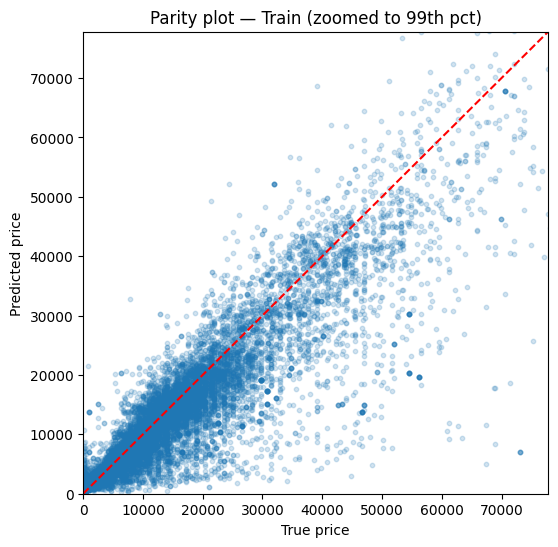

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_train_true, y_train_pred, alpha=0.2, s=10)
maxv = np.percentile(np.concatenate([y_train_true, y_train_pred]), 99)
plt.xlim(0, maxv); plt.ylim(0, maxv)
plt.plot([0, maxv],[0, maxv], 'r--')
plt.xlabel("True price"); plt.ylabel("Predicted price")
plt.title("Parity plot — Train (zoomed to 99th pct)")
plt.show()

In [ ]:
best_model = XGBRegressor(subsample=1.0, reg_lambda=2, reg_alpha=0, n_estimators=800,
                                 max_depth=10, learning_rate=0.05, colsample_bytree=0.8,
                                 objective='reg:squarederror', verbosity=0, random_state=42)

In [ ]:
import joblib

joblib.dump(best_model, "Best_Model.pkl")
print("Saved Best_Model.pkl")

Saved Best_Model.pkl
